In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import cv2, os, re
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle, json
from time import time
import logging
import torch

from src.scripts.models.Pix2Vox import Encoder, Decoder, Merger, Refiner
from src.scripts.losses import DiceBCELoss, IoULoss
from config import cfg

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def init_weights(m):
    if type(m) == torch.nn.Conv2d or type(m) == torch.nn.Conv3d or \
            type(m) == torch.nn.ConvTranspose2d or type(m) == torch.nn.ConvTranspose3d:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.BatchNorm2d or type(m) == torch.nn.BatchNorm3d:
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, 0, 0.01)
        torch.nn.init.constant_(m.bias, 0)

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else: device = 'cpu'

In [5]:
from src.scripts.data_loaders_p2v import DATASET_LOADER_MAPPING, DatasetType
from src.scripts import data_transforms

In [6]:
# def test_net(cfg,
#              epoch_idx=-1,
#              test_data_loader=None,
#              encoder=None,
#              decoder=None,
#              refiner=None,
#              merger=None):

#     # Enable the inbuilt cudnn auto-tuner to find the best algorithm to use
#     torch.backends.cudnn.benchmark = True

#     # Load taxonomies of dataset
#     taxonomies = []
#     with open(cfg.DATASETS[cfg.DATASET.TEST_DATASET.upper()].TAXONOMY_FILE_PATH, encoding='utf-8') as file:
#         taxonomies = json.loads(file.read())
#     taxonomies = {t['taxonomy_id']: t for t in taxonomies}

#     # Set up data loader
#     if test_data_loader is None:
#         # Set up data augmentation
#         IMG_SIZE = cfg.CONST.IMG_H, cfg.CONST.IMG_W
#         CROP_SIZE = cfg.CONST.CROP_IMG_H, cfg.CONST.CROP_IMG_W
#         test_transforms = data_transforms.Compose([
#             # data_transforms.CenterCrop(IMG_SIZE, CROP_SIZE),
#             # utils.data_transforms.RandomBackground(cfg.TEST.RANDOM_BG_COLOR_RANGE),
#             data_transforms.Normalize(mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD),
#             data_transforms.ToTensor(),
#         ])

#         # dataset_loader = utils.data_loaders.DATASET_LOADER_MAPPING[cfg.DATASET.TEST_DATASET](cfg)
#         dataset_loader = DATASET_LOADER_MAPPING[cfg.DATASET.TEST_DATASET](cfg)
#         test_data_loader = torch.utils.data.DataLoader(dataset=dataset_loader.get_dataset(
#                 DatasetType.TEST, cfg.CONST.N_VIEWS_RENDERING, test_transforms),
#             batch_size=1,
#             num_workers=cfg.CONST.NUM_WORKER,
#             pin_memory=True,
#             shuffle=False)

#     # Set up loss functions
#     # loss_func = utils.helpers.get_loss_function(cfg)
#     # Testing loop
#     n_samples = len(test_data_loader)
#     test_iou = dict()

#     # Switch models to evaluation mode
#     encoder.eval()
#     decoder.eval()
#     refiner.eval()
#     merger.eval()

#     for sample_idx, (taxonomy_id, sample_name, rendering_images, ground_truth_volume) in enumerate(test_data_loader):
#         taxonomy_id = taxonomy_id[0] if isinstance(taxonomy_id[0], str) else taxonomy_id[0].item()
#         sample_name = sample_name[0]

#         with torch.no_grad():
#             # Get data from data loader
#             rendering_images = rendering_images.cuda()
#             ground_truth_volume = ground_truth_volume.cuda()

#             # Test the encoder, decoder, refiner and merger
#             image_features = encoder(rendering_images)
#             raw_features, generated_volume = decoder(image_features)

#             if cfg.NETWORK.USE_MERGER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_MERGER:
#                 generated_volume = merger(raw_features, generated_volume)
#             else:
#                 generated_volume = torch.mean(generated_volume, dim=1)
#             encoder_loss = loss_func(generated_volume, ground_truth_volume) * 10

#             if cfg.NETWORK.USE_REFINER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_REFINER:
#                 generated_volume = refiner(generated_volume)
#                 refiner_loss = loss_func(generated_volume, ground_truth_volume) * 10
#             else:
#                 refiner_loss = encoder_loss

#             # IoU per sample
#             sample_iou = []
#             for th in cfg.TEST.VOXEL_THRESH:
#                 _volume = torch.ge(generated_volume, th).float()
#                 intersection = torch.sum(_volume.mul(ground_truth_volume)).float()
#                 union = torch.sum(torch.ge(_volume.add(ground_truth_volume), 1)).float()
#                 sample_iou.append((intersection / union).item())

#             # IoU per taxonomy
#             if taxonomy_id not in test_iou:
#                 test_iou[taxonomy_id] = {'n_samples': 0, 'iou': []}
#             test_iou[taxonomy_id]['n_samples'] += 1
#             test_iou[taxonomy_id]['iou'].append(sample_iou)

#             # # Append generated volumes to TensorBoard
#             # if cfg.TEST.VOL_OR_RENDER_SAVE.lower() == 'render':
#             #     if test_writer and sample_idx < cfg.CONST.TEST_SAVE_NUMBER:
#             #         # Volume Visualization
#             #         rendering_views = utils.helpers.get_volume_views(generated_volume.cpu().numpy())
#             #         test_writer.add_image('Model%02d/Reconstructed' % sample_idx, rendering_views, epoch_idx)
#             #         rendering_views = utils.helpers.get_volume_views(ground_truth_volume.cpu().numpy())
#             #         test_writer.add_image('Model%02d/GroundTruth' % sample_idx, rendering_views, epoch_idx)
#             # elif cfg.TEST.VOL_OR_RENDER_SAVE.lower() == 'volume':
#             #     # if test_writer and sample_idx < cfg.CONST.TEST_SAVE_NUMBER:
#             #     utils.helpers.save_test_volumes_as_np(cfg, generated_volume, sample_idx, epoch_idx)
#             # else:
#             #     raise Exception(
#             #         '[FATAL] %s Invalid input for save format %s. voxels' % (dt.now(), cfg.TEST.VOL_OR_RENDER_SAVE))

#             # Print sample loss and IoU
#             logging.info('Test[%d/%d] Taxonomy = %s Sample = %s EDLoss = %.4f RLoss = %.4f IoU = %s' %
#                          (sample_idx + 1, n_samples, taxonomy_id, sample_name, encoder_loss.item(),
#                           refiner_loss.item(), ['%.4f' % si for si in sample_iou]))

#     if cfg.DIR.IOU_SAVE_PATH:
#         df = pd.DataFrame(
#             np.hstack((test_iou[taxonomy_id]['iou'], np.atleast_2d(np.max(test_iou[taxonomy_id]['iou'], axis=1)).T)),
#             columns=[*cfg.TEST.VOXEL_THRESH, 'max_iou'])
#         # writer = pd.ExcelWriter(, engine='xlsxwriter')
#         # df.to_excel(writer, index=False)
#         # writer.save()
#         # df.to_excel(cfg.DIR.IOU_SAVE_PATH, index=False)
        

#     mean_iou = []
#     for taxonomy_id in test_iou:
#         test_iou[taxonomy_id]['iou'] = np.mean(test_iou[taxonomy_id]['iou'], axis=0)
#         mean_iou.append(test_iou[taxonomy_id]['iou'] * test_iou[taxonomy_id]['n_samples'])
#     mean_iou = np.sum(mean_iou, axis=0) / n_samples

#     # Print header
#     print('============================ TEST RESULTS ============================')
#     print('Taxonomy', end='\t')
#     print('#Sample', end='\t')
#     print('Baseline', end='\t')
#     for th in cfg.TEST.VOXEL_THRESH:
#         print('t=%.2f' % th, end='\t')
#     print()
#     # Print body
#     for taxonomy_id in test_iou:
#         print('%s' % taxonomies[taxonomy_id]['taxonomy_name'].ljust(8), end='\t')
#         print('%d' % test_iou[taxonomy_id]['n_samples'], end='\t')
#         if 'baseline' in taxonomies[taxonomy_id]:
#             # print('%.4f' % taxonomies[taxonomy_id]['baseline']['%d-view' % cfg.CONST.N_VIEWS_RENDERING], end='\t\t')
#             print('Ignoring baseline')
#         else:
#             print('N/a', end='\t\t')

#         for ti in test_iou[taxonomy_id]['iou']:
#             print('%.4f' % ti, end='\t')
#         print()
#     # Print mean IoU for each threshold
#     print('Overall ', end='\t\t\t\t')
#     for mi in mean_iou:
#         print('%.4f' % mi, end='\t')
#     print('\n')

#     # Add testing results to TensorBoard
#     max_iou = np.max(mean_iou)

#     return max_iou

In [7]:
from src.scripts.test_Pix2Vox import test_net

In [8]:
# Set up data augmentation
IMG_SIZE = cfg.CONST.IMG_H, cfg.CONST.IMG_W
CROP_SIZE = cfg.CONST.CROP_IMG_H, cfg.CONST.CROP_IMG_W
train_transforms = data_transforms.Compose([
    # utils.data_transforms.RandomCrop(IMG_SIZE, CROP_SIZE),
    # utils.data_transforms.RandomBackground(cfg.TRAIN.RANDOM_BG_COLOR_RANGE),
    # data_transforms.ColorJitter(cfg.TRAIN.BRIGHTNESS, cfg.TRAIN.CONTRAST, cfg.TRAIN.SATURATION),
    # utils.data_transforms.RandomNoise(cfg.TRAIN.NOISE_STD),
    data_transforms.Normalize(mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD),
    # utils.data_transforms.RandomFlip(),
    # utils.data_transforms.RandomPermuteRGB(),
    data_transforms.ToTensor()
])
val_transforms = data_transforms.Compose([
    # utils.data_transforms.CenterCrop(IMG_SIZE, CROP_SIZE),
    # utils.data_transforms.RandomBackground(cfg.TEST.RANDOM_BG_COLOR_RANGE),
    # utils.data_transforms.ColorJitter(cfg.TRAIN.BRIGHTNESS, cfg.TRAIN.CONTRAST, cfg.TRAIN.SATURATION),
    data_transforms.Normalize(mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD),
    data_transforms.ToTensor()
])

# Set up data loader
# train_dataset_loader = data_loaders.DATASET_LOADER_MAPPING[cfg.DATASET.TRAIN_DATASET](cfg)
# val_dataset_loader = utils.data_loaders.DATASET_LOADER_MAPPING[cfg.DATASET.TEST_DATASET](cfg)
train_dataset_loader = DATASET_LOADER_MAPPING[cfg.DATASET.TRAIN_DATASET](cfg)
val_dataset_loader = DATASET_LOADER_MAPPING[cfg.DATASET.TEST_DATASET](cfg)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset_loader.get_dataset(
    DatasetType.TRAIN, cfg.CONST.N_VIEWS_RENDERING, train_transforms),  # 
    batch_size=cfg.CONST.BATCH_SIZE,
    # num_workers=cfg.CONST.NUM_WORKER,
    pin_memory=True,
    shuffle=True,
    drop_last=True)
val_data_loader = torch.utils.data.DataLoader(dataset=val_dataset_loader.get_dataset(
    DatasetType.VAL, cfg.CONST.N_VIEWS_RENDERING, val_transforms),
    batch_size=1,
    # num_workers=cfg.CONST.NUM_WORKER,
    pin_memory=True,
    shuffle=False)

[{'taxonomy_id': 'heart', 'taxonomy_name': 'heart_seg', 'baseline': {'1-view': 0.555, '2-view': 0.666}, 'train': ['full_heart_mesh_001', 'full_heart_mesh_002', 'full_heart_mesh_003', 'full_heart_mesh_004', 'full_heart_mesh_005', 'full_heart_mesh_006', 'full_heart_mesh_007', 'full_heart_mesh_008', 'full_heart_mesh_009', 'full_heart_mesh_010', 'full_heart_mesh_011', 'full_heart_mesh_012', 'full_heart_mesh_013', 'full_heart_mesh_014', 'full_heart_mesh_015', 'full_heart_mesh_016', 'full_heart_mesh_017', 'full_heart_mesh_018', 'full_heart_mesh_019', 'full_heart_mesh_020'], 'test': ['full_heart_mesh_021', 'full_heart_mesh_022'], 'val': ['full_heart_mesh_023', 'full_heart_mesh_024', 'full_heart_mesh_025']}]
[{'taxonomy_id': 'heart', 'taxonomy_name': 'heart_seg', 'baseline': {'1-view': 0.555, '2-view': 0.666}, 'train': ['full_heart_mesh_001', 'full_heart_mesh_002', 'full_heart_mesh_003', 'full_heart_mesh_004', 'full_heart_mesh_005', 'full_heart_mesh_006', 'full_heart_mesh_007', 'full_heart_mes

In [9]:
# Set up networks
encoder = Encoder(cfg).to(device)
decoder = Decoder(cfg).to(device)
refiner = Refiner(cfg).to(device)
merger = Merger(cfg).to(device)

print('Parameters in Encoder: %d.' % (count_parameters(encoder)))
print('Parameters in Decoder: %d.' % (count_parameters(decoder)))
print('Parameters in Refiner: %d.' % (count_parameters(refiner)))
print('Parameters in Merger: %d.' % (count_parameters(merger)))


Parameters in Encoder: 1847710.
Parameters in Decoder: 9216504.
Parameters in Refiner: 34943920.
Parameters in Merger: 8571.


In [10]:
# Initialize weights of networks
encoder.apply(init_weights)
decoder.apply(init_weights)
refiner.apply(init_weights)
merger.apply(init_weights)

# Set up solver
if cfg.TRAIN.POLICY == 'adam':
    encoder_solver = torch.optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()),
                                      lr=cfg.TRAIN.ENCODER_LEARNING_RATE,
                                      betas=cfg.TRAIN.BETAS)
    decoder_solver = torch.optim.Adam(decoder.parameters(),
                                      lr=cfg.TRAIN.DECODER_LEARNING_RATE,
                                      betas=cfg.TRAIN.BETAS)
    refiner_solver = torch.optim.Adam(refiner.parameters(),
                                      lr=cfg.TRAIN.REFINER_LEARNING_RATE,
                                      betas=cfg.TRAIN.BETAS)
    merger_solver = torch.optim.Adam(merger.parameters(), lr=cfg.TRAIN.MERGER_LEARNING_RATE, betas=cfg.TRAIN.BETAS)
else:
    raise Exception('[FATAL] %s Unknown optimizer %s.' % (dt.now(), cfg.TRAIN.POLICY))

In [11]:
# Set up learning rate scheduler to decay learning rates dynamically
encoder_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(encoder_solver,
                                                            milestones=cfg.TRAIN.ENCODER_LR_MILESTONES,
                                                            gamma=cfg.TRAIN.GAMMA)
decoder_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(decoder_solver,
                                                            milestones=cfg.TRAIN.DECODER_LR_MILESTONES,
                                                            gamma=cfg.TRAIN.GAMMA)
refiner_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(refiner_solver,
                                                            milestones=cfg.TRAIN.REFINER_LR_MILESTONES,
                                                            gamma=cfg.TRAIN.GAMMA)
merger_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(merger_solver,
                                                            milestones=cfg.TRAIN.MERGER_LR_MILESTONES,
                                                            gamma=cfg.TRAIN.GAMMA)

In [12]:
# Set up loss functions
loss_func = torch.nn.BCELoss()   # DiceBCELoss, IoULoss

# Load pretrained model if exists
init_epoch = 0
best_iou = -1
best_epoch = -1

In [13]:
from random import random

In [14]:
for epoch_idx in range(init_epoch, cfg.TRAIN.NUM_EPOCHS):
    # Tick / tock
    epoch_start_time = time()

    # switch models to training mode
    encoder.train()
    decoder.train()
    merger.train()
    refiner.train()

    batch_end_time = time()
    n_batches = len(train_data_loader)
    for batch_idx, (taxonomy_names, sample_names, rendering_images,
                    ground_truth_volumes) in enumerate(train_data_loader):

        # Get data from data loader
        if torch.cuda.is_available():
            rendering_images = rendering_images.cuda(non_blocking=True)            # ([8, 1, 3, 224, 224])    ([8, 64, 64, 64])
            ground_truth_volumes = ground_truth_volumes.cuda(non_blocking=True)

        # Train the encoder, decoder, refiner, and merger
        image_features = encoder(rendering_images)     # ([8, 1, 256, 7, 7])
        raw_features, generated_volumes = decoder(image_features)     # generated_volumes shape is ([8, 1, 32, 32, 32])

        if cfg.NETWORK.USE_MERGER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_MERGER:
            generated_volumes = merger(raw_features, generated_volumes)
        else:
            generated_volumes = torch.mean(generated_volumes, dim=1)

        encoder_loss = loss_func(generated_volumes, ground_truth_volumes) * 10

        if cfg.NETWORK.USE_REFINER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_REFINER:
            generated_volumes = refiner(generated_volumes)
            refiner_loss = loss_func(generated_volumes, ground_truth_volumes) * 10
        else:
            refiner_loss = encoder_loss

        # Gradient decent
        encoder.zero_grad()
        decoder.zero_grad()
        refiner.zero_grad()
        merger.zero_grad()

        if cfg.NETWORK.USE_REFINER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_REFINER:
            encoder_loss.backward(retain_graph=True)
            refiner_loss.backward()
        else:
            encoder_loss.backward()

        encoder_solver.step()
        decoder_solver.step()
        refiner_solver.step()
        merger_solver.step()

        print(f"Encoder loss:   {encoder_loss.item()}, \nrefiner_loss:   {refiner_loss.item()}")

    # Adjust learning rate
    encoder_lr_scheduler.step()
    decoder_lr_scheduler.step()
    refiner_lr_scheduler.step()
    merger_lr_scheduler.step()

    # Tick / tock
    epoch_end_time = time()

    # print('[Epoch %d/%d] EpochTime = %.3f (s) EDLoss = %.4f RLoss = %.4f' % (epoch_idx + 1, cfg.TRAIN.NUM_EPOCHS, epoch_end_time - epoch_start_time, encoder_loss.item(), refiner_loss.item()))

    # Update Rendering Views
    if cfg.TRAIN.UPDATE_N_VIEWS_RENDERING:
        n_views_rendering = random.randint(1, cfg.CONST.N_VIEWS_RENDERING)
        train_data_loader.dataset.set_n_views_rendering(n_views_rendering)
        logging.info('Epoch [%d/%d] Update #RenderingViews to %d' %
                        (epoch_idx + 2, cfg.TRAIN.NUM_EPOCHS, n_views_rendering))

    # Validate the training models
    iou = test_net(cfg, epoch_idx + 1, val_data_loader, 
                   encoder, decoder, refiner, merger)  # cfg,  epoch_idx, encoder, decoder, refiner, merger

    # Save weights to file
    if (epoch_idx + 1) % cfg.TRAIN.SAVE_FREQ == 0 or iou > best_iou:
        file_name = 'checkpoint-epoch-%03d.pth' % (epoch_idx + 1)
        if iou > best_iou:
            best_iou = iou
            best_epoch = epoch_idx
            file_name = 'checkpoint-best.pth'

        output_path = os.path.join(cfg.DIR.CHECKPOINTS, file_name)
        if not os.path.exists(cfg.DIR.CHECKPOINTS):
            os.makedirs(cfg.DIR.CHECKPOINTS)

        with open(os.path.join(cfg.DIR.OUT_PATH, 'train_test_config.json'), 'w') as fp:
            json.dump(cfg, fp, indent=4)
            fp.close()

        checkpoint = {
            'epoch_idx': epoch_idx,
            'best_iou': best_iou,
            'best_epoch': best_epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
        }
        if cfg.NETWORK.USE_REFINER:
            checkpoint['refiner_state_dict'] = refiner.state_dict()
        if cfg.NETWORK.USE_MERGER:
            checkpoint['merger_state_dict'] = merger.state_dict()

        torch.save(checkpoint, output_path)
        logging.info('Saved checkpoint to %s ...' % output_path)

Encoder loss:   18.469402313232422, 
refiner_loss:   12.824480056762695
Encoder loss:   18.652610778808594, 
refiner_loss:   9.835915565490723
============================ TEST RESULTS ============================
Taxonomy	#Sample	Baseline	t=0.20	t=0.30	t=0.40	t=0.50	t=0.60	t=0.70	t=0.80	t=0.90	
heart_seg	3	Ignoring baseline
0.1851	0.1852	0.1874	0.1926	0.1877	0.1870	0.1798	0.1581	
Overall 				0.1851	0.1852	0.1874	0.1926	0.1877	0.1870	0.1798	0.1581	

Encoder loss:   18.6563777923584, 
refiner_loss:   8.488346099853516
Encoder loss:   17.912322998046875, 
refiner_loss:   7.74934196472168
============================ TEST RESULTS ============================
Taxonomy	#Sample	Baseline	t=0.20	t=0.30	t=0.40	t=0.50	t=0.60	t=0.70	t=0.80	t=0.90	
heart_seg	3	Ignoring baseline
0.1852	0.1861	0.1901	0.1970	0.1747	0.1739	0.1716	0.1586	
Overall 				0.1852	0.1861	0.1901	0.1970	0.1747	0.1739	0.1716	0.1586	

Encoder loss:   16.33028793334961, 
refiner_loss:   7.176236629486084
Encoder loss:   14.7327566

In [15]:
# Get predict and Visualize 

In [16]:
points = np.load('data/train/Heart/heart_seg/voxels/full_heart_mesh_001/model.npy')
print(f"points shape = {points.shape}")

points shape = (64, 64, 64)


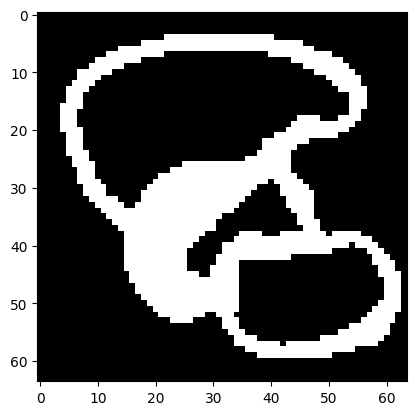

In [17]:
from matplotlib import pyplot as plt

plt.imshow(points[25], cmap='gray')
plt.show()

torch.Size([8, 64, 64, 64])


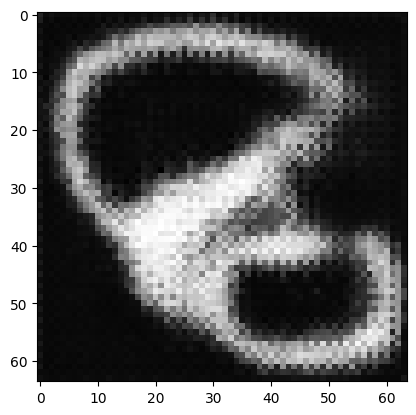

In [18]:
pred = generated_volumes.detach().cpu()
print(pred.shape)
plt.imshow(pred[0][25], cmap='gray')
plt.show()

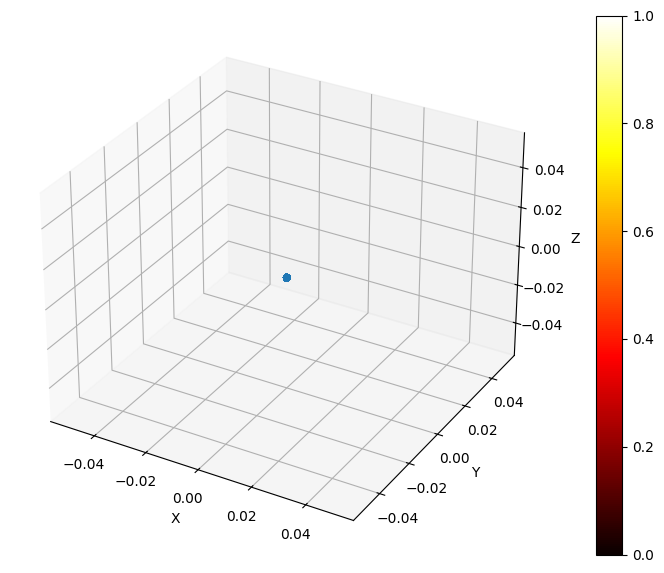

In [19]:
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(x, y, z, cmap=plt.hot())
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [20]:
def train_net():
    # Training loop
    for epoch_idx in range(init_epoch, cfg.TRAIN.NUM_EPOCHS):
        # Tick / tock
        epoch_start_time = time()

        # switch models to training mode
        encoder.train()
        decoder.train()
        merger.train()
        refiner.train()

        batch_end_time = time()
        n_batches = len(train_data_loader)
        for batch_idx, (taxonomy_names, sample_names, rendering_images,
                        ground_truth_volumes) in enumerate(train_data_loader):

            # Get data from data loader
            if torch.cuda.is_available():
                rendering_images = rendering_images.cuda(non_blocking=True)
                ground_truth_volumes = ground_truth_volumes.cuda(non_blocking=True)

            # Train the encoder, decoder, refiner, and merger
            image_features = encoder(rendering_images)
            raw_features, generated_volumes = decoder(image_features)

            if cfg.NETWORK.USE_MERGER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_MERGER:
                generated_volumes = merger(raw_features, generated_volumes)
            else:
                generated_volumes = torch.mean(generated_volumes, dim=1)
            encoder_loss = loss_func(generated_volumes, ground_truth_volumes) * 10

            if cfg.NETWORK.USE_REFINER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_REFINER:
                generated_volumes = refiner(generated_volumes)
                refiner_loss = loss_func(generated_volumes, ground_truth_volumes) * 10
            else:
                refiner_loss = encoder_loss

            # Gradient decent
            encoder.zero_grad() 
            decoder.zero_grad()
            refiner.zero_grad()
            merger.zero_grad()

            if cfg.NETWORK.USE_REFINER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_REFINER:
                encoder_loss.backward(retain_graph=True)
                refiner_loss.backward()
            else:
                encoder_loss.backward()

            encoder_solver.step()
            decoder_solver.step()
            refiner_solver.step()
            merger_solver.step()

            # Append loss to average metrics
            # encoder_losses.update(encoder_loss.item())
            # refiner_losses.update(refiner_loss.item())
            # Append loss to TensorBoard
            # n_itr = epoch_idx * n_batches + batch_idx
            # train_writer.add_scalar('EncoderDecoder/BatchLoss', encoder_loss.item(), n_itr)
            # train_writer.add_scalar('Refiner/BatchLoss', refiner_loss.item(), n_itr)

            print(f"Encoder loss:   {encoder_loss.item()}, \nrefiner_loss:   {refiner_loss.item()}")

            # Tick / tock
            # batch_time.update(time() - batch_end_time)
            # batch_end_time = time()
            # logging.info(
            #     '[Epoch %d/%d][Batch %d/%d] BatchTime = %.3f (s) DataTime = %.3f (s) EDLoss = %.4f RLoss = %.4f' %
            #     (epoch_idx + 1, cfg.TRAIN.NUM_EPOCHS, batch_idx + 1, n_batches, batch_time.val, data_time.val,
            #         encoder_loss.item(), refiner_loss.item()))

        # Adjust learning rate
        encoder_lr_scheduler.step()
        decoder_lr_scheduler.step()
        refiner_lr_scheduler.step()
        merger_lr_scheduler.step()

        # Append epoch loss to TensorBoard
        # train_writer.add_scalar('EncoderDecoder/EpochLoss', encoder_losses.avg, epoch_idx + 1)
        # train_writer.add_scalar('Refiner/EpochLoss', refiner_losses.avg, epoch_idx + 1)

        # Tick / tock
        epoch_end_time = time()
        print('[Epoch %d/%d] EpochTime = %.3f (s) EDLoss = %.4f RLoss = %.4f' % (epoch_idx + 1, cfg.TRAIN.NUM_EPOCHS, epoch_end_time - epoch_start_time, ))
        # logging.info('[Epoch %d/%d] EpochTime = %.3f (s) EDLoss = %.4f RLoss = %.4f' %
        #                 (epoch_idx + 1, cfg.TRAIN.NUM_EPOCHS, epoch_end_time - epoch_start_time, encoder_losses.avg,
        #                 refiner_losses.avg))

        # Update Rendering Views
        if cfg.TRAIN.UPDATE_N_VIEWS_RENDERING:
            n_views_rendering = random.randint(1, cfg.CONST.N_VIEWS_RENDERING)
            train_data_loader.dataset.set_n_views_rendering(n_views_rendering)
            logging.info('Epoch [%d/%d] Update #RenderingViews to %d' %
                            (epoch_idx + 2, cfg.TRAIN.NUM_EPOCHS, n_views_rendering))

        # Validate the training models
        iou = test_net(cfg, epoch_idx + 1, val_data_loader, val_writer, encoder, decoder, refiner, merger)

        # Save weights to file
        if (epoch_idx + 1) % cfg.TRAIN.SAVE_FREQ == 0 or iou > best_iou:
            file_name = 'checkpoint-epoch-%03d.pth' % (epoch_idx + 1)
            if iou > best_iou:
                best_iou = iou
                best_epoch = epoch_idx
                file_name = 'checkpoint-best.pth'

            output_path = os.path.join(cfg.DIR.CHECKPOINTS, file_name)
            if not os.path.exists(cfg.DIR.CHECKPOINTS):
                os.makedirs(cfg.DIR.CHECKPOINTS)

            with open(os.path.join(cfg.DIR.OUT_PATH, 'train_test_config.json'), 'w') as fp:
                json.dump(cfg, fp, indent=4)
                fp.close()

            checkpoint = {
                'epoch_idx': epoch_idx,
                'best_iou': best_iou,
                'best_epoch': best_epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
            }
            if cfg.NETWORK.USE_REFINER:
                checkpoint['refiner_state_dict'] = refiner.state_dict()
            if cfg.NETWORK.USE_MERGER:
                checkpoint['merger_state_dict'] = merger.state_dict()

            torch.save(checkpoint, output_path)
            logging.info('Saved checkpoint to %s ...' % output_path)